# Pedestrian Fatality Risk, by age: estimation with sklearn and logistic regression 

This notebook explores a massive French dataset on traffic incidents from 2005-2016, containing almost 1 million 
incidents. Using various forms of regression and other ML-based approaches, models are built to estimate age as a
predictor of fatality rate for pedestrians, scooter riders, and drivers. 

All data can be found on kaggle: 
    
https://www.kaggle.com/ahmedlahlou/accidents-in-france-from-2005-to-2016/download#vehicles.csv
    
Note that this dataset lacks some interesting features, such as vehicle speed. Nonetheless, it is a large, mostly
complete dataset, and thus it is a good tool for estimating overall fatality rates, even if those rates have a number
of implicit variables. 

In [3]:
import pandas as pd
import numpy as np

#ML-specific libraries:

from sklearn.utils import resample
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 

#For plotting:

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bokeh.plotting import figure, show, output_file

### Import datasets. Note that the encoding on these datasets is ISO-8859-1


In [4]:
caracteristics = pd.read_csv("caracteristics.csv", encoding='ISO-8859-1', index_col=0) # french character encoding?
vehicles = pd.read_csv("vehicles.csv", encoding='ISO-8859-1', index_col=0) # french character encoding?
places = pd.read_csv("places.csv", encoding='ISO-8859-1', index_col=0) # french character encoding?
users = pd.read_csv("users.csv", encoding='ISO-8859-1', index_col=0) # french character encoding?

/Users/ryanmdalton/Desktop/CODE/cities_and_populations/transit/transit_in_france/frenchdata/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/ryanmdalton/Desktop/CODE/cities_and_populations/transit/transit_in_france/frenchdata/lib/python3.6/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/Users/ryanmdalton/Desktop/CODE/cities_and_populations/transit/transit_in_france/frenchdata/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Explore the data a bit, to determine which attributes to keep and which to discard. 

In [5]:
road_data = caracteristics[['lum', 'int' , 'atm', 'an']] #lighting conditions, intersection type, atmospheric conditions, year of accident
place_data = places[['catr', 'circ', 'vosp', 'larrout']] # category of road, traffic regime, reserved lane, roadway width
user_data = users[['catu', 'grav', 'sexe', 'an_nais']] #user category, severity, awz, yob, safety equipment
vehicle_data = vehicles[['catv']] #vehicle category

In [6]:
#rename columns. For all column descriptors, go to kaggle.

road_data.rename(columns={'lum':'lighting', 'int':'intersection_type', 'atm':'atmospheric_conditions', 
                          'an':'accident_year'}, inplace=True)
place_data.rename(columns={'catr':'road_type', 'circ':'traffic_type', 
                           'vosp':'reserved_lane', 'larrout':'road_width'}, inplace=True)
user_data.rename(columns={'catu':'user_type', 'grav':'severity', 'sexe':'sex', 'an_nais':'yob'}, inplace=True)
vehicle_data.rename(columns={'catv':'vehicle_category'}, inplace=True)

/Users/ryanmdalton/Desktop/CODE/cities_and_populations/transit/transit_in_france/frenchdata/lib/python3.6/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [7]:
all_data = place_data.join(user_data).join(vehicle_data).join(road_data) #join all data:

all_data.to_csv("french_collision_data.csv") #save a local copy to play with 

### Take a look at pedestrian data specifically:

In [8]:
#filter for just pedestrians (categories 3 and 4, which excludes scooters, rollerblades):

pedestrian_data = all_data[all_data['user_type'] == 3] #this gives us ~162k records
pedestrian_data.head()

,road_type,traffic_type,reserved_lane,road_width,user_type,severity,sex,yob,vehicle_category,lighting,intersection_type,atmospheric_conditions,accident_year
Num_Acc,,,,,,,,,,,,,
200500000010,2.0,0.0,0.0,70.0,3,3,1,1962.0,7,3,1,2.0,5
200500000014,3.0,2.0,0.0,59.0,3,3,2,1936.0,7,5,1,2.0,5
200500000015,3.0,2.0,0.0,106.0,3,3,2,1938.0,7,5,1,1.0,5
200500000020,4.0,2.0,0.0,0.0,3,4,1,1952.0,7,5,1,2.0,5
200500000020,4.0,2.0,0.0,0.0,3,4,1,1949.0,7,5,1,2.0,5


In [9]:
#filter data such that all fatal accidents = 1 and nonfatal = 0. 

pedestrian_data['fatal'] = np.where(pedestrian_data['severity'] == 2, 1, 0)
pedestrian_data['age'] = 2000 + pedestrian_data['accident_year'] - pedestrian_data['yob'] #Add an 'age' column. 

/Users/ryanmdalton/Desktop/CODE/cities_and_populations/transit/transit_in_france/frenchdata/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ryanmdalton/Desktop/CODE/cities_and_populations/transit/transit_in_france/frenchdata/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### Prepare data for ML

In [10]:
pedestrian_data.describe() # get a handle on what the data looks like. Identify good attributes. 

,road_type,traffic_type,reserved_lane,road_width,user_type,severity,sex,yob,vehicle_category,lighting,intersection_type,atmospheric_conditions,accident_year,fatal,age
count,161840.000000,161640.000000,161475.000000,160083.000000,161840.0,161840.000000,161840.000000,161700.000000,161840.000000,161840.000000,161840.000000,161828.000000,161840.000000,161840.000000,161700.000000
mean,3.874679,1.715287,0.192160,51.667166,3.0,3.473795,1.516584,1969.159629,10.746342,1.846083,1.657489,1.565601,10.195520,0.044964,41.038955
std,1.133293,0.730749,0.687981,60.187819,0.0,0.686406,0.499726,26.075057,11.316246,1.523510,1.549601,1.607486,3.454617,0.207226,25.912698
min,1.000000,0.000000,0.000000,-81.000000,3.0,1.000000,1.000000,1898.000000,1.000000,1.000000,0.000000,1.000000,5.000000,0.000000,0.000000
25%,3.000000,1.000000,0.000000,0.000000,3.0,3.000000,1.000000,1947.000000,7.000000,1.000000,1.000000,1.000000,7.000000,0.000000,17.000000
50%,4.000000,2.000000,0.000000,55.000000,3.0,4.000000,2.000000,1972.000000,7.000000,1.000000,1.000000,1.000000,10.000000,0.000000,39.000000
75%,4.000000,2.000000,0.000000,77.000000,3.0,4.000000,2.000000,1993.000000,7.000000,2.000000,2.000000,1.000000,13.000000,0.000000,63.000000
max,9.000000,4.000000,3.000000,999.000000,3.0,4.000000,2.000000,2016.000000,99.000000,5.000000,9.000000,9.000000,16.000000,1.000000,109.000000


In [11]:
#Note that there is no traffic type = 0 attribute on kaggle; these are probably fields that were not filled. 

pedestrian_data = pedestrian_data[pedestrian_data['traffic_type'] != 0] #no match in files for 0 designation

pedestrian_data = pedestrian_data[['traffic_type', 'age', 'sex', 'fatal']].dropna() #restrict to interesting vars

### Resample

Note that there is a class imbalance: only about 1% of these records are for fatal accidents. This is an issue because many ML algorithms are trained to minimize overall accuracy, and to do so they could just always classify accidents as nonfatal, which would give an accuracy of 99%.

To correct this:

-get number of instances for minority class

-downsample (since our dataset is large)

In [12]:
majority_df = pedestrian_data[pedestrian_data['fatal'] == 0] #nonfatal
minority_df = pedestrian_data[pedestrian_data['fatal'] == 1] #fatal
print(len(minority_df), ",", len(majority_df)) #check the relative lengths of our classes

6929 , 142904


In [13]:
#downsampling procedure (uses sklearn's resample method):

majority_df_downsampled = resample(majority_df, replace=True, n_samples=len(minority_df), random_state=0)

#Merge dfs: 

df_resampled = pd.concat([minority_df, majority_df_downsampled]) 

df_resampled['fatal'].value_counts() #note that we now have equal numbers of fatal and non-fatal ped accidents:

1    6929
0    6929
Name: fatal, dtype: int64

### Build dummy variables for categorical attributes:

Almost all of the attributes in this dataset are categorical (ie male vs female). This presents some challenges, and
limits our analysis in certain ways. One thing to keep in mind is that some of these variables are currently written 
as though continuous (ie 1, 2, 3, 4), which they are not. We need to convert them to one-hot encoded variables, 
for which the pandas get_dummies method is useful:

In [14]:
sex = pd.get_dummies(df_resampled.sex).rename(columns={1:'male',2:'female'})
age_vector = df_resampled['age']
X = pd.concat([sex, age_vector], axis=1) #these are our attributes, and a pandas df is a fine place for them
y = df_resampled['fatal'].values #these are our labels, and sklearn likes them as a 1d array

### Now for the ML

-we will need to:
    
    -split the data into train/test sets. We can do this with train_test_split from sklearn
    
    -choose a model. We are predicting a categorical variable, so logistic regression makes sense to start with. 
    
    -train the model with the train sets
    
    -use that model to make predictions

In [15]:
#split our data into trainining and test sets:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

logistic_reg = LogisticRegression(solver='lbfgs')
logistic_reg.fit(X_train, y_train)

print("coefficients = ", logistic_reg.coef_) #spit out our coefficients, which map to male, female, and age variables

score = logistic_reg.score(X_test, y_test)
print("score = ", score) #our accuracy on the test sets

coefficients =  [[-0.06083205 -0.85830805  0.02795233]]
score =  0.6785714285714286


68% accuracy is not fantastic, but given how few predictors we have here, it's not bad. Let's now plot our predictions 
versus age as an explanatory variable. Note that logistic regression outputs a label, based on a probability. And 
our logistic regression instance has the 'proba' method, which spits out class probabilities instead. Once we have our predictions in hand, we can plot them, color-coding by whether the prediction was accurate. 


In [16]:
predictions = logistic_reg.predict(X_test) #outputs categories only
probabilities = logistic_reg.predict_proba(X_test)
probabilities #these predictions come out as probabilities of belonging to class 0 versus 1 (ie nonfatal vs fatal)

array([[0.39058948, 0.60941052],
       [0.45876592, 0.54123408],
       [0.33260955, 0.66739045],
       ...,
       [0.63678767, 0.36321233],
       [0.33884318, 0.66115682],
       [0.44492033, 0.55507967]])

In [17]:
#build a correct v incorrect color list:

col_list = []
for i in range(len(y_test)):
    if y_test[i] == predictions[i]: col_list.append('black')
    else: col_list.append('red')

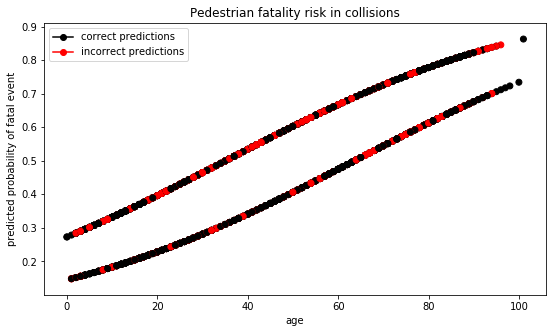

In [18]:
### Plot our data. Use x = age, y = probability, color = incorrect vs correct:

fig, ax = plt.subplots(figsize=(9,5))
legend_elements = [Line2D([0], [0], marker='o', color='black', label='correct predictions'), 
                  Line2D([0], [0], marker='o', color='red', label='incorrect predictions')]
plt.scatter(X_test['age'], probabilities[:,1], color=col_list)
ax.legend(handles=legend_elements, loc='upper left')
plt.ylabel("predicted probability of fatal event")
plt.xlabel("age")
plt.title("Pedestrian fatality risk in collisions")
plt.show()

### Is this a male versus female regression line?

This looks interesting. Remember that we are using the categorical variable of m/f in our model. It looks like we are 
getting two distinct regression lines, mapping to male versus female variables. To ask whether this is the case, let's
remove that category for an overall regressor, then look at regressors for just that category. 


In [19]:
#separate our datasets into three, then split them, train regressors, and make predictions as before:

X_a = pd.concat([age_vector], axis=1) #age only


X_a_train, X_a_test, y_train, y_test = train_test_split(X_a, y, test_size=.2, random_state=0)
logistic_reg_a = LogisticRegression(solver='lbfgs')
logistic_reg_a.fit(X_a_train, y_train)
a_probabilities = logistic_reg_a.predict_proba(X_a_test)
a_predictions = logistic_reg_a.predict(X_a_test)


X_f = pd.concat([age_vector, sex], axis=1) #female only 

X_f['y'] = y
X_f = X_f[X_f['female'] == 1].drop(columns=['male'])
y_f = X_f['y'].values
X_f = X_f.drop(columns=['y'])

X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_f, y_f, test_size=.2, random_state=0)
logistic_reg_f = LogisticRegression(solver='lbfgs')
logistic_reg_f.fit(X_f_train, y_f_train)
f_probabilities = logistic_reg_f.predict_proba(X_f_test)
f_predictions = logistic_reg_f.predict(X_f_test)

X_m = pd.concat([age_vector, sex], axis=1) #male only

X_m['y'] = y
X_m = X_m[X_m['male'] == 1].drop(columns=['female'])
y_m = X_m['y'].values
X_m = X_m.drop(columns=['y'])

X_m_train, X_m_test, y_m_train, y_m_test = train_test_split(X_m, y_m, test_size=.2, random_state=0)
logistic_reg_m = LogisticRegression(solver='lbfgs')
logistic_reg_m.fit(X_m_train, y_m_train)
m_probabilities = logistic_reg_m.predict_proba(X_m_test)
m_predictions = logistic_reg_m.predict(X_m_test)

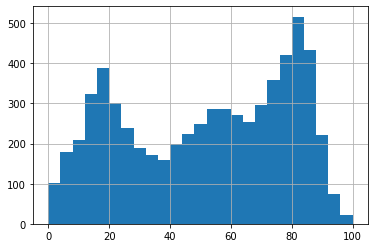

In [26]:
#let's take a peek at whether there is structure in incidents across ages for females and males. 

X_f['age'].hist(bins=25)

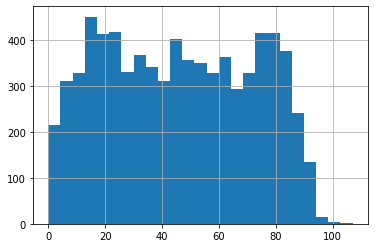

In [28]:
X_m['age'].hist(bins=25)

Super interesting! It would be useful to normalize this to the percentage of the population per age group, such that 
we get a sense of the rates of involvement in collisions by age. But already it is clear that the structure between 
males and females is different--males maintain a high rate of collision involvement that looks age-invariant. Rather than chase that down, let's look at our regressors. 

In [31]:
# first, a delightful color scheme:

gold = "#F2D936"
navy = "#1E3066"
light_blue = "#2BC2E8"

In [32]:
# sort our data so we can use it for a line plot:

X_f_test['probs'] = [i[1] for i in f_probabilities]
X_m_test['probs'] = [i[1] for i in m_probabilities]
X_a_test['probs'] = [i[1] for i in a_probabilities]

X_f_test.sort_values(by=['age'], inplace=True)
X_m_test.sort_values(by=['age'], inplace=True)
X_a_test.sort_values(by=['age'], inplace=True)

/Users/ryanmdalton/Desktop/CODE/cities_and_populations/transit/transit_in_france/frenchdata/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ryanmdalton/Desktop/CODE/cities_and_populations/transit/transit_in_france/frenchdata/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/ryanmda

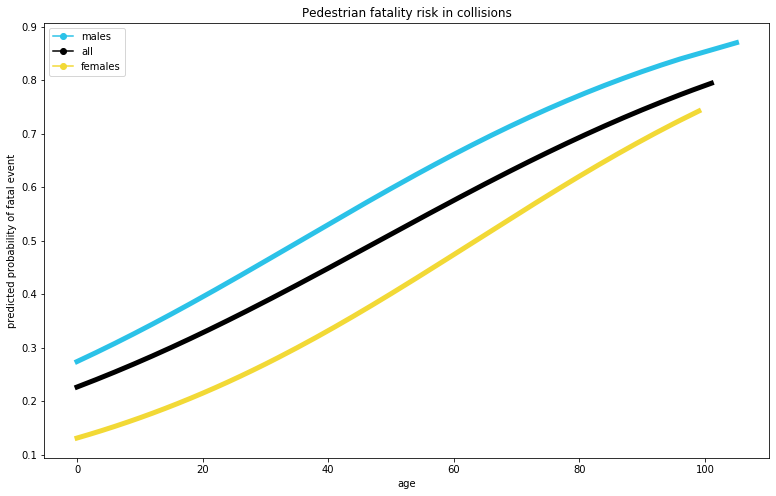

In [34]:
fig, ax = plt.subplots(figsize=(13,8))
legend_elements = [Line2D([0], [0], marker='o', color=light_blue, label='males'), 
                  Line2D([0], [0], marker='o', color='black', label='all'), 
                  Line2D([0], [0], marker='o', color=gold, label='females')]
plt.plot(X_m_test['age'], X_m_test['probs'], color=light_blue, linewidth=5)
plt.plot(X_a_test['age'], X_a_test['probs'], color='black', linewidth=5)
plt.plot(X_f_test['age'], X_f_test['probs'], color=gold, linewidth=5)
ax.legend(handles=legend_elements, loc='upper left')
plt.ylabel("predicted probability of fatal event")
plt.xlabel("age")
plt.title("Pedestrian fatality risk in collisions")
plt.show()